# Hand-written digit recognization from scratch

## Problem

Given observable data (this is the original training data, which will usually be partially extracted as validation data): 
$$\{(\textbf{x}^{(1)}, y^{(1)}), ..., (\textbf{x}^{(N_{train})}, y^{(N_{train})})\}$$

In this:

- $\textbf{x}^{(n)} \in \mathbb{R}^{784}$ is the input vector containing the pixel values of a grayscale image $28\times28$, which is an image of some handwritten digit (784$ dimensional vector generated from a $28\times28$ grayscale image by concatenation. lines of grayscale image together)
- $y^{(n)} \in \{0, 1, ..., 9\}$ is the corresponding output, indicating which digit this is

The task here is to find a Neural Network model (include preprocessing if any) from this data so that this Neural Network model (include preprocessing if any) can take an image as input- alphanumeric *new* (which is a vector $\in \mathbb{R}^{784}$) and predict the corresponding output (which digit is in $\{0, 1, 2 , ..., 9\}$) *exactly*.

## Import libraries

In [1]:
import numpy as np
import os
import pickle
import gzip
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Để hình vẽ đẹp hơn một xíu ...

## Read data

The data set in this article is MNIST, the popular hand-written digital data set in Machine Learning. [Original MNIST kit](http://yann.lecun.com/exDB/mnist/) consists of: Training data (60000 images) and verification data (10,000 images). The MNIST package used in this article (" Mnist.PKL.GZ "file) includes: Training data (50,000 photos), Validation data (10,000 images), and test data (10,000 images); The training and validation data here were created by separating the original training data in two parts in a 5:1 ratio.
 
The validation data and test data were both new data aside from the training data. Validation data are the same as the test subject, which can be tried several times; The test data, as in the case of a real test, can only be taken objectively. When we make Machine Learning, we often want to try a number of pre-processed + models to determine the best way pre-processed + models. With each predation + model, we will train on training data and measure the predicted error on validation data; We will eventually choose the former processing + model which has the lowest predictive error rate on the validation data (we chose not to rely on the predicted error on the training data because it is possible for "parrots" : preprocessing + models with very low error on training data but with high error on new data beyond the training data). Once we have chosen the preprocessor - model then, we measure the only estimated error rate on the test data to get an objective estimate of the actual amount of error! If you look at the predicted error on the test data and go back to adjusting how preprocessing + models, then the result on the test data is not objectively present!

The following code will read data from file "mnist.pkl.gz" and save to 6 matrixes:

- `train_X`, `train_y`
- `val_X`, `val_y`
- `test_X`, `test_y`

In [2]:
def read_mnist(mnist_file):
    if os.path.isfile(mnist_file) == False:
        mnist_file = os.path.join(os.path.expanduser('~'), 'data', 'mnist.pkl.gz')
    
    f = gzip.open(mnist_file, 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    
    train_X, train_Y = train_data
    val_X, val_Y = val_data
    test_X, test_Y = test_data    
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

train_X, train_y, val_X, val_y, test_X, test_y = read_mnist('mnist.pkl.gz')
print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_y.shape}')
print(f'Shape of val_X:   {val_X.shape}, shape of val_y:   {val_y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_y.shape}')

Shape of train_X: (50000, 784), shape of train_y: (50000,)
Shape of val_X:   (10000, 784), shape of val_y:   (10000,)
Shape of test_X:  (10000, 784), shape of test_y:  (10000,)


## Explore train data

Min & Max of `train_X`.

In [3]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')

Min of train_X: 0.0, max of train_X: 0.99609375


For grayscale images, the value of each pixel is usually in the range [0, 255] (where 0 is black and 255 is white), or sometimes normalized to the interval [0, 1] (where 0 is black and 1 is white). Here it seems that the pixel value of our grayscale image is in the range [0, 1].

Next, let show some image in `train_X`.

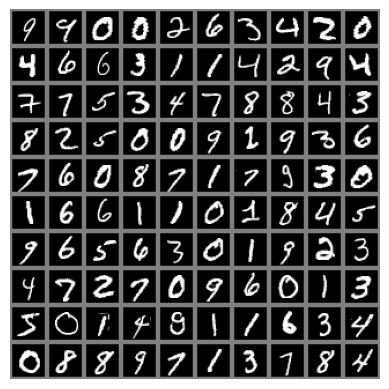

In [4]:
# YOu can run this cell multiple times to watch other images
n_rimages = 10; n_cimages = 10 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (28 + 2 * padding), n_cimages * (28 + 2 * padding)))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])
for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(28, 28)
        temp1 = r * (28 + 2 * padding) + padding 
        temp2 = c * (28 + 2 * padding) + padding 
        canvas[temp1:temp1 + 28, temp2:temp2 + 28] = image
plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
plt.axis('off');

Next, Let look over the values of `train_y` and quantity of each value.

In [5]:
values, counts = np.unique(train_y, return_counts=True)
for value, count in zip(values, counts):
    print(f'Value: {value}, count: {count}')

Value: 0, count: 4932
Value: 1, count: 5678
Value: 2, count: 4968
Value: 3, count: 5101
Value: 4, count: 4859
Value: 5, count: 4506
Value: 6, count: 4951
Value: 7, count: 5175
Value: 8, count: 4842
Value: 9, count: 4988


Thus `train_y` has 10 possible values for 10 digits from 0 to 9. And the number of images of each digit is also quite similar.

## Preprocessing train data

In [6]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

# Call add_ones to preprocess train_X
train_Z = add_ones(train_X)
train_Z.shape

(50000, 785)

## Find Neural Network model from training data

In this project, we will work with a simple architecture of the Neural Network model: Fully-Connected Feed-Forward Neural Network. We will use the sigmoid activation function in the hidden layer and the softmax function in the output layer. Thus, we can consider our Neural Network model as a Softmax Regression model that has an input vector of $\textbf{z}$ with $\textbf{z}$ calculated from the original input vector. $\textbf{x}$ through hidden layers. The big idea of the Neural Network model is that the model will automatically learn how to determine the input vector $\textbf{z}$ from the data, instead of humans having to think about how to design $\textbf{ z}$. The advantage of this approach of the Neural Network model is that people can let the computer run and drink coffee :-). But the downside is that the model will have more parameters (weights) to learn, and therefore more data will be needed to learn well; this also means that it will need more powerful computers, longer training, more electricity costs, more CO2 emissions into the environment :-( Another disadvantage is that humans may not understand vectors. the input $\textbf{z}$ that the model gives.In terms of prediction accuracy, up to now, the Neural Network model is the model that achieves very good prediction accuracy with image data, audio, text.

Write `compute_nnet_output` function. This function will be used in the `train_nnet` function below; In addition, after training is complete, this function will be used to predict the outputs of the new input vectors.

The `compute_nnet_output` function takes the following input parameters:
- `Ws`: list containing the weight arrays of the Neural Network model. `Ws[l-1]` is the weight array of `l` layer with `l` >= 1 (layer 0 is input layer, no weight array); weight array of layer `l` whose shape is <font color=blue>(</font>1 + number of neurons of layer `l-1`<font color=blue>,</font> number of neurons) -ron of the layer `l`<font color=blue>)</font> with "the number of neurons of the layer" is not counting neurons but always has an output value of 1
- `X`: array containing input vectors to be predicted (with 1 added at the beginning), this array has a shape of (`N`, `d+1`) where `N` is the number of vectors -input vector and `d` is the number of elements of each input vector (without adding 1 at the beginning)
- `return_what`: if this parameter is `all`, it will return a list containing the output-vector-containing arrays at all levels (we will need to use this list during training) ); if this parameter is equal to `prob`, it will return an array containing the output vectors at the output layer, each output vector indicating the probability of classes of the corresponding input vector; if this parameter is equal to `class` or other values, returns an array containing the predicted output classes, the predicted output class of an input vector is the class that has the greatest probability in the vector the output contains the probabilities of the classes

The `compute_nnet_output` function will return:

- If `return_what` is equal to `all`, it returns a list containing the output-vector arrays at all layers, including layer 0 (the input layer). The index element `i` of this list is an array containing the output vectors of the `i` layer corresponding to the input vectors of `X`; This array has a shape of (`N`, 1 + the number of neurons of layer `i`) if the array is not the last element of the list ("1 + ..." corresponds to the value 1 of the node. -ron which always has an output value of 1), and if this array is the last element of the list (the output layer) it will have a shape of (`N`, the number of neurons of the `i` layer). Again: "the number of neurons of the layer" is not counting neurons but always has an output value of 1, `N` is the number of input vectors of `X`
- If `return_what` is equal to `prob`, it will return an array containing the output vectors at the output layer that correspond to the input vectors of `X`, each output vector containing the probabilities of class of the corresponding input vector; This array has a shape of (`N`, number of layers)
- If `return_what` is equal to `class` or other values, returns an array containing the predicted output classes corresponding to the input vectors of `X`, the predicted output class of a vector the input is the class that has the greatest probability in the output vector containing the probabilities of the classes; This array has a shape of (`N`,)

In [7]:
def compute_nnet_output(Ws, X, return_what='class'):
    # YOUR CODE HERE
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def softmax(Z):
        e_Z = np.exp(Z)
        A = e_Z / e_Z.sum()
        return A

    res = []
    neural = X
    res.append(neural)
    for w in Ws[:-1]:
        neural = np.hstack((np.ones((neural.shape[0], 1)), sigmoid(neural @ w)))
        res.append(neural)
    
    res.append(np.apply_along_axis(softmax, axis=1, arr=(neural @ Ws[-1])))

    if return_what == 'all':
        return res
    elif return_what == 'prob':
        return res[-1]    
    else:
        return np.argmax(res[-1], 1)

Write a function `train_nnet` to train a Neural Network model with cross-entropy error and SGD (Stochastic Gradient Descent) minimization algorithm.

The `train_nnet` function takes the following input parameters:
- `X`, `y`, `initial_Ws`, `mb_size`, `lr`, `max_epoch`: same as in HW3, I won't repeat it again. A slight difference from HW3 is that `initial_W` has been replaced with `initial_Ws` (with s), since we now have not just an array of weights but a list of arrays of weights. In addition, compared to HW3, here we only use `max_epoch` to interrupt SGD, not `wanted_mbe` (in HW3, we add `wanted_mbe` mainly to compare GD and SGD)
- `hid_layer_sizes`: list shows the number of neurons of the hidden layers (not counting neurons but always has an output value of 1); for example, list `[20, 10]` means that our Neural Network has 2 hidden layers, in which the first hidden layer has 20 neurons, the second hidden layer has 10 neurons.

The `train_nnet` function returns:
- List contains the weight array of the Neural Network model. The index element `l-1` of this list is the weight array of the `l` layer with `l` >= 1 (layer 0 is the input layer, no weights array); weight array of layer `l` whose shape is <font color=blue>(</font>1 + number of neurons of layer `l-1`<font color=blue>,</font> number of neurons) -ron of the layer `l`<font color=blue>)</font> with "the number of neurons of the layer" is not counting neurons but always has an output value of 1
- List contains the cross-entropy error on the training data after each epoch

At each mini-batch, we have to update not only the weights of the Softmax Regression model for the output layer, but also the weights of the previous hidden layers.

As we know, in SGD, to update a weight we need to average over the mini-batch the partial derivative of the error-of-one-sample-training-data against this weight. Consider the connection weights from neuron i of layer l-1 to neuron j of layer l. After applying the "chain rule", we have the formula to calculate the partial derivative of the error-of-one-sample-training-data with this weight:

Partial derivative <font color=blue>=</font> output value of neuron i at layer l-1 <font color=blue>*</font> delta of neuron j at layer l

Where the delta of a neuron is the partial derivative of the error-of-one-sample-training-data over the weighted sum (the value calculated just before the activation function is applied) of the neuron -ron this.

Below is the pseudocode of the SGD algorithm to train the Neural Network model.

===

Initialize the weights (note: with Neural Network, the way the weights are initialized will greatly affect the results found by SGD)

For each epoch (an epoch refers to one traversal of all training data samples):
- Randomly shuffle the training data samples
- Split the training data samples into mini-batches of equal size (this size is specified by the user). For each mini-batch:
    1. Perform forward propagation of input vectors through Neural Network to obtain output vectors at all layers
    2. Calculate the delta vectors of the last layer from the output vectors of the last layer (the vector containing the probabilities of the classes) and the correct output vectors of the mini-batch (the one-hot vector) )
    3. Calculate the gradient (eigenways) of the last layer from the output vectors of the last layer and the delta vectors of the last layer
    4. Update the weights of the terminal layer based on the gradient
    5. Browse from the next floor to the top. For floor i:
    1. Calculate the delta vectors of layer i from the delta vectors of layer i+1, the weights of layer i+1, and the output vectors of layer i
    2. Calculate the gradient (eigenways) of layer i from the output vectors of layer i-1 and delta vectors of layer i
    3. Update the weights of layer i based on gradient

===

In [8]:
def train_nnet(X, y, hid_layer_sizes, initial_Ws, mb_size, lr, max_epoch):
    # Initialize weights
    n_classes = len(np.unique(y)) 
    if initial_Ws is None:
        layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [n_classes]
        Ws = [np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1]) 
              / np.sqrt(layer_sizes[i] + 1) 
              for i in range(len(layer_sizes) - 1)] 
    else:
        Ws = initial_Ws
    
    # Build model
    prob_y = np.apply_along_axis(lambda x : np.eye(10)[x, :], axis=0, arr=y)

    n_mb = int(X.shape[0] / mb_size)
    index_arr = np.arange(X.shape[0])
    cross_entropy = []
    for epoch in range(max_epoch):
        np.random.shuffle(index_arr)
        
        for b in range(n_mb):
            batch_X = X[index_arr[b * mb_size : (b + 1) * mb_size], :]
            batch_prob_y = prob_y[index_arr[b * mb_size : (b + 1) * mb_size], :]
            
            all_layer_output = compute_nnet_output(Ws, batch_X, 'all')
            delta = all_layer_output[-1] - batch_prob_y
            Ws[-1] -= lr * (1/mb_size) * (all_layer_output[-2].T @ delta)

            for l in range(len(hid_layer_sizes)-1, -1, -1):
                delta = delta.dot(Ws[l + 1].T[:, 1:]) * all_layer_output[l + 1][:, 1:] * (1 - all_layer_output[l + 1][:, 1:])
                Ws[l] -= lr * (1/mb_size) * (all_layer_output[l].T @ delta)
        
        cross_entropy.append((1 / X.shape[0]) * ((prob_y * np.log(compute_nnet_output(Ws, X, 'prob'))).sum(axis=1) * -1).sum())

    return Ws, cross_entropy

call the function `train_nnet` to find the weights of the Neural Network model from `train_Z` and `train_y`.

CPU times: total: 6min 54s
Wall time: 2min 36s


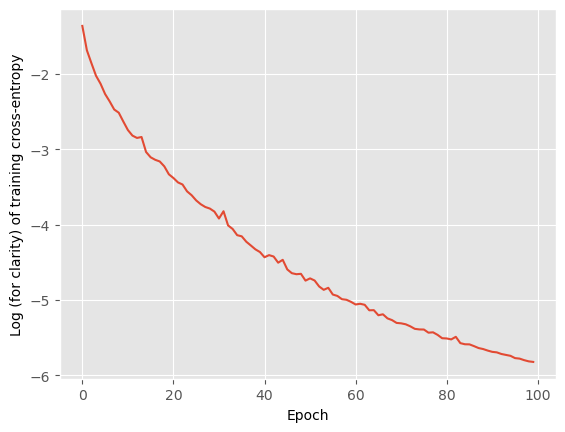

In [9]:
%%time
Ws_1, train_ces = train_nnet(
    train_Z, train_y,
    hid_layer_sizes=[50], 
    initial_Ws=None, mb_size=32, lr=0.3, max_epoch=100)
plt.plot(np.log(train_ces))
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy');

## Evaluation by train data and validation data

In [10]:
def compute_mbe(predicted_y, y):
    return np.mean(predicted_y != y) * 100

In [11]:
predicted_train_y = compute_nnet_output(Ws_1, train_Z, return_what='class')
train_mbe = compute_mbe(predicted_train_y, train_y)

val_Z = add_ones(val_X)
predicted_val_y = compute_nnet_output(Ws_1, val_Z, return_what='class')
val_mbe = compute_mbe(predicted_val_y, val_y)

test_Z = add_ones(test_X)
predicted_test_y = compute_nnet_output(Ws_1, test_Z, return_what='class')
test_mbe = compute_mbe(predicted_test_y, test_y)

print('MBE on train set:', train_mbe)
print('MSE on validation set:', val_mbe)
print('MSE on test set:', test_mbe)

MBE on train set: 0.0
MSE on validation set: 2.68
MSE on test set: 2.8899999999999997


**&rarr;** It's not overfitting when all three train, validation and test MBE score is acceptable!

## Build Neural Network from whole dataset for deploying

In [12]:
Z = np.vstack((train_Z, val_Z, test_Z))
y = np.hstack((train_y, val_y, test_y))

CPU times: total: 9min 3s
Wall time: 3min 48s


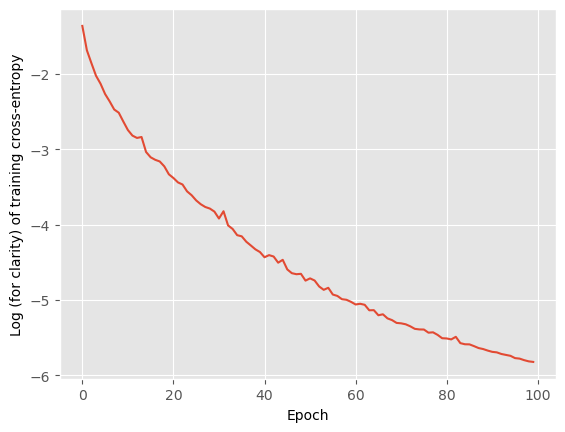

In [13]:
%%time
Ws, ces = train_nnet(
    Z, y,
    hid_layer_sizes=[50], 
    initial_Ws=None, mb_size=32, lr=0.3, max_epoch=100)
plt.plot(np.log(train_ces))
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy');